<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/2025_nfl_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  font

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# nfl draft data

In [ ]:
!pip install -U pandas
!pip install catboost
!pip install nfl_data_py

<IPython.core.display.Javascript object>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 108.5 MB/s eta 0:00:00
  Attempting uninstall: nump

In [ ]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
import os
from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>

In [ ]:
spotrac = pd.read_csv('spotrac.csv')
players = nfl.import_players()
_df = players.loc[:, ['draft_club', 'draft_number', 'draftround', 'entry_year','gsis_id']].dropna().drop_duplicates().rename(columns={'draft_club':'team','draft_number':'pick','draftround':'round','entry_year':'season','gsis_id':'gsis_id2'})
for y in ['round','pick','season']:
  _df[y] = _df[y].astype(int)

spotrac.columns = spotrac.columns.str.lower().str.strip().str.replace(' ','_')
for y in spotrac.columns[1:]:
  spotrac[y] = spotrac[y].str.replace('$','').str.replace(',','').astype(float)
  spotrac = spotrac.rename(columns={y:f'spotrac_{y}'})

ids = nfl.import_ids()
draft_picks = nfl.import_draft_picks(range(1999,2025))
draft_picks = draft_picks.merge(_df, how='left')
draft_picks['gsis_id'] = draft_picks['gsis_id'].fillna(draft_picks['gsis_id2'])
draft_picks = draft_picks.drop(columns=['gsis_id2'])
draft_value = nfl.import_draft_values()
for y in ['stuart', 'johnson', 'hill', 'otc', 'pff']:
  draft_value[f"{y}_z"] = minmax_scale(draft_value[y])

contracts = nfl.import_contracts()
contracts = contracts.loc[:, ['gsis_id', 'years','value','guaranteed']].groupby(['gsis_id'],as_index=False).sum()
contracts['apy'] = contracts['value'].div(contracts['years'])
contracts['gapy'] = contracts['guaranteed'].div(contracts['years'])
df = draft_picks.merge(contracts, on='gsis_id', how='left').merge(draft_value, how='left').merge(spotrac, how='left')
pos_map = {
    'QB':'QB',
    'RB':'RB',
    'WR':'WR',
    'TE':'TE',
    'DB':'DB',
    'CB':'DB',
    'LB':'LB',
    'ILB':'LB',
    'T':'T',
    'OT':'T',
    'FB':'FB',
    'K':'K',
    'P':'P',
    'FB':'FB',
    'LS':'LS',
    'G':'G',
    'OG':'G',
    'C':'G',
    'OL':'G',
    'S':'S',
    'SAF':'S',
    'FS':'S',
    'OLB':'EDGE',
    'DE':'EDGE',
    'DT':'DT',
    'DL':'DT',
    'NT':'DT'
}
df['position'] = df['position'].map(pos_map)
df.shape

<IPython.core.display.Javascript object>

<ipython-input-3-a83caa0d2b49>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  spotrac[y] = spotrac[y].str.replace('$','').str.replace(',','').astype(float)
<ipython-input-3-a83caa0d2b49>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  spotrac[y] = spotrac[y].str.replace('$','').str.replace(',','').astype(float)
<ipython-input-3-a83caa0d2b49>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  spotrac[y] = spotrac[y].str.replace('$','').str.replace(',','').astype(float)
<ipython-input-3-a83caa0d2b49>:9: FutureWarning: The

(6640, 56)

In [ ]:
df_agg = df.loc[:, ['round','pick','seasons_started', 'w_av', 'car_av', 'dr_av','allpro', 'probowls','years', 'value', 'guaranteed', 'apy', 'gapy','stuart', 'johnson', 'hill', 'otc', 'pff','stuart', 'johnson_z', 'hill_z', 'otc_z', 'pff_z', 'spotrac_total_value']].groupby(['round','pick'],as_index=False).mean()
df_agg['spotrac_total_value'] = df_agg['spotrac_total_value'].div(1000000)
for y in ['johnson_z', 'hill_z', 'otc_z', 'pff_z']:
  df_agg[f'value_{y}'] = (df_agg[y].mul(df.loc[df['pick']==1,'spotrac_total_value'].values[0])).div(1000000)
df_agg.head()

<IPython.core.display.Javascript object>

<ipython-input-4-7e43db1eaf94>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_agg = df.loc[:, ['round','pick','seasons_started', 'w_av', 'car_av', 'dr_av','allpro', 'probowls','years', 'value', 'guaranteed', 'apy', 'gapy','stuart', 'johnson', 'hill', 'otc', 'pff','stuart', 'johnson_z', 'hill_z', 'otc_z', 'pff_z', 'spotrac_total_value']].groupby(['round','pick'],as_index=False).mean()


,round,pick,seasons_started,w_av,dr_av,allpro,probowls,years,value,guaranteed,...,stuart,johnson_z,hill_z,otc_z,pff_z,spotrac_total_value,value_johnson_z,value_hill_z,value_otc_z,value_pff_z
0,1,1,6.692308,64.269231,46.520000,0.269231,2.076923,11.631579,199.370679,142.396939,...,34.6,1.000000,1.000000,1.000000,1.000000,43.010000,43.010000,43.010000,43.010000,43.010000
1,1,2,5.692308,49.384615,39.000000,0.538462,2.153846,9.850000,104.602480,69.167479,...,30.2,0.866667,0.716887,0.875512,0.966942,41.108290,37.275333,30.833305,37.655754,41.588182
2,1,3,5.730769,43.230769,37.500000,0.538462,2.346154,10.900000,110.621701,72.586028,...,27.6,0.733333,0.513844,0.802524,0.933884,39.898136,31.540667,22.100424,34.516552,40.166364
3,1,4,6.461538,49.615385,33.840000,0.384615,2.307692,10.263158,108.538401,70.889195,...,25.8,0.600000,0.490010,0.751023,0.900826,38.515052,25.806000,21.075331,32.301508,38.744545
4,1,5,6.269231,50.346154,39.923077,0.730769,2.192308,9.944444,107.998293,76.253340,...,24.3,0.566667,0.467277,0.710778,0.867769,36.094688,24.372333,20.097596,30.570546,37.322727


<IPython.core.display.Javascript object>

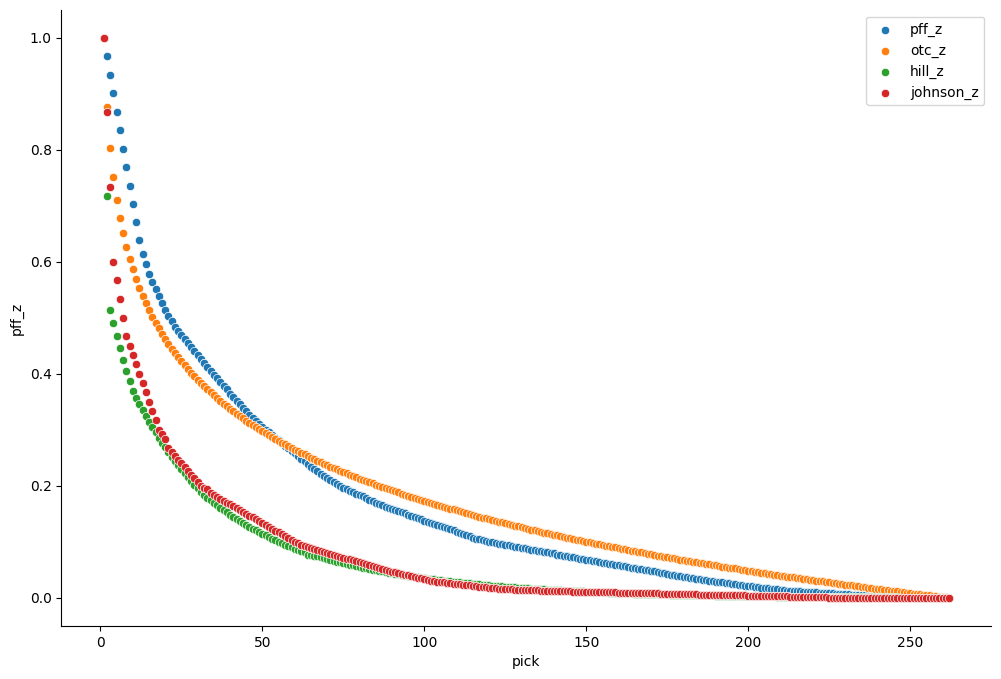

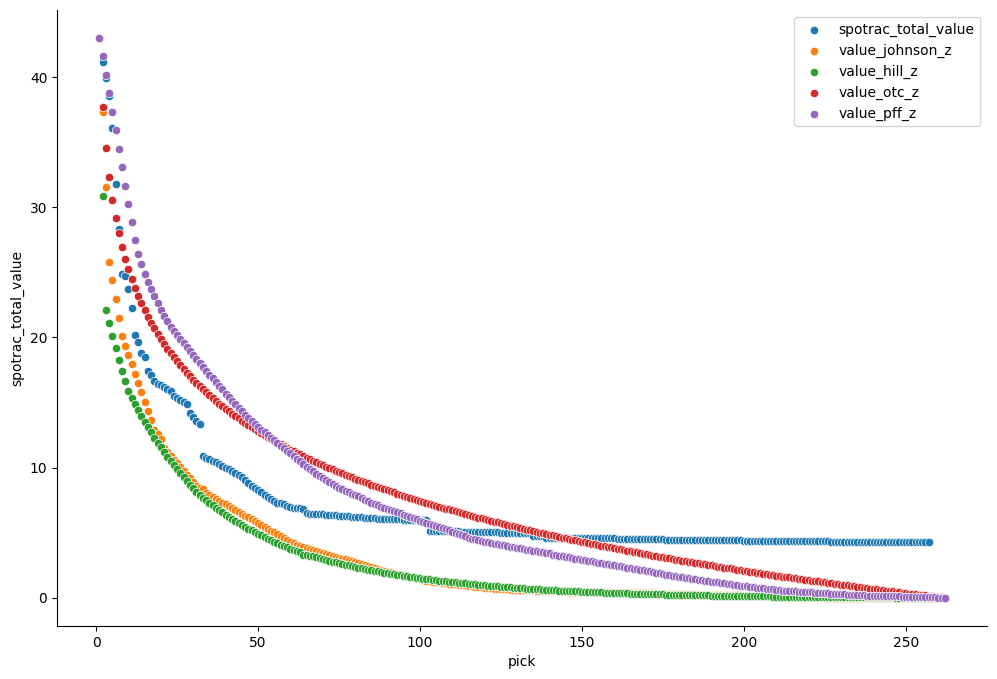

In [ ]:
f = plt.figure(figsize=(12,8))
for y in ['pff_z','otc_z','hill_z','johnson_z']:
  sns.scatterplot(data=df_agg, x='pick', y=y,label=y)
sns.despine()
plt.show()

f = plt.figure(figsize=(12,8))
for y in ['spotrac_total_value','value_johnson_z', 'value_hill_z', 'value_otc_z', 'value_pff_z']:
  sns.scatterplot(data=df_agg, x='pick', y=y,label=y)
sns.despine()
plt.show()

In [ ]:
df_agg.head(40)

<IPython.core.display.Javascript object>

,round,pick,seasons_started,w_av,dr_av,allpro,probowls,years,value,guaranteed,...,stuart,johnson_z,hill_z,otc_z,pff_z,spotrac_total_value,value_johnson_z,value_hill_z,value_otc_z,value_pff_z
0,1,1,6.692308,64.269231,46.520000,0.269231,2.076923,11.631579,199.370679,142.396939,...,34.6,1.000000,1.000000,1.000000,1.000000,43.010000,43.010000,43.010000,43.010000,43.010000
1,1,2,5.692308,49.384615,39.000000,0.538462,2.153846,9.850000,104.602480,69.167479,...,30.2,0.866667,0.716887,0.875512,0.966942,41.108290,37.275333,30.833305,37.655754,41.588182
2,1,3,5.730769,43.230769,37.500000,0.538462,2.346154,10.900000,110.621701,72.586028,...,27.6,0.733333,0.513844,0.802524,0.933884,39.898136,31.540667,22.100424,34.516552,40.166364
3,1,4,6.461538,49.615385,33.840000,0.384615,2.307692,10.263158,108.538401,70.889195,...,25.8,0.600000,0.490010,0.751023,0.900826,38.515052,25.806000,21.075331,32.301508,38.744545
4,1,5,6.269231,50.346154,39.923077,0.730769,2.192308,9.944444,107.998293,76.253340,...,24.3,0.566667,0.467277,0.710778,0.867769,36.094688,24.372333,20.097596,30.570546,37.322727
5,1,6,5.923077,45.769231,37.230769,0.461538,1.769231,11.631579,111.486793,79.051995,...,23.2,0.533333,0.445596,0.678035,0.834711,31.772616,22.938667,19.165067,29.162306,35.900909
6,1,7,5.807692,45.000000,31.615385,0.423077,1.769231,11.470588,121.692241,82.900228,...,22.2,0.500000,0.424925,0.650409,0.801653,28.314964,21.505000,18.276021,27.974103,34.479091
7,1,8,4.846154,38.000000,25.346154,0.423077,1.115385,8.937500,75.433476,51.218679,...,21.4,0.466667,0.405205,0.626535,0.768595,24.857308,20.071333,17.427876,26.947261,33.057273
8,1,9,5.500000,43.115385,36.192308,0.692308,1.653846,9.923077,64.656129,44.333532,...,20.6,0.450000,0.386396,0.605389,0.735537,24.684224,19.354500,16.618909,26.037773,31.635455
9,1,10,5.076923,38.280000,30.840000,0.346154,1.038462,10.055556,72.567090,42.014084,...,19.9,0.433333,0.368458,0.586289,0.702479,23.733556,18.637667,15.847398,25.216299,30.213636


In [ ]:
df_agg.loc[df_agg['pick'].isin([32, 164]) & (df_agg['round']!=6) & (df_agg['round']!=2), ['round','spotrac_total_value','value_johnson_z', 'value_hill_z', 'value_otc_z', 'value_pff_z']].sum()

<IPython.core.display.Javascript object>

,0
round,6.000000
spotrac_total_value,17.879494
value_johnson_z,8.831387
value_hill_z,8.221842
value_otc_z,19.847384
value_pff_z,20.300404


In [ ]:
df_agg.loc[(df_agg['pick'].isin([31])) & (df_agg['round']!=10)].sum()

<IPython.core.display.Javascript object>

,0
round,1.000000
pick,31.000000
seasons_started,4.192308
w_av,31.346154
dr_av,24.653846
allpro,0.346154
probowls,1.038462
years,8.444444
value,37.692106
guaranteed,20.833598


In [ ]:
round_pos = df.loc[df['seasons_started']>5, ['round','position','years', 'value', 'guaranteed', 'apy', 'gapy']].groupby(['round','position'],as_index=False).mean()
round_pos.head(40)

<IPython.core.display.Javascript object>

,round,position,years,value,guaranteed,apy,gapy
0,1,DB,13.676471,93.980061,55.481566,6.993445,4.328546
1,1,DT,12.421053,117.356945,73.126078,9.847992,6.176579
2,1,EDGE,13.846154,130.736230,84.985559,9.830972,6.493410
3,1,G,11.538462,81.172327,52.114095,7.183229,4.700747
4,1,LB,13.111111,106.198571,60.086263,8.098297,4.768304
5,1,QB,16.166667,301.918558,189.797475,19.363259,12.296875
6,1,RB,13.125000,73.944969,40.117721,5.506099,3.105938
7,1,S,9.000000,72.720655,46.292255,7.982132,5.082512
8,1,T,13.250000,125.445528,75.182219,9.499103,5.880535
9,1,TE,12.444444,53.787555,29.232853,4.136524,2.238009


<IPython.core.display.Javascript object>

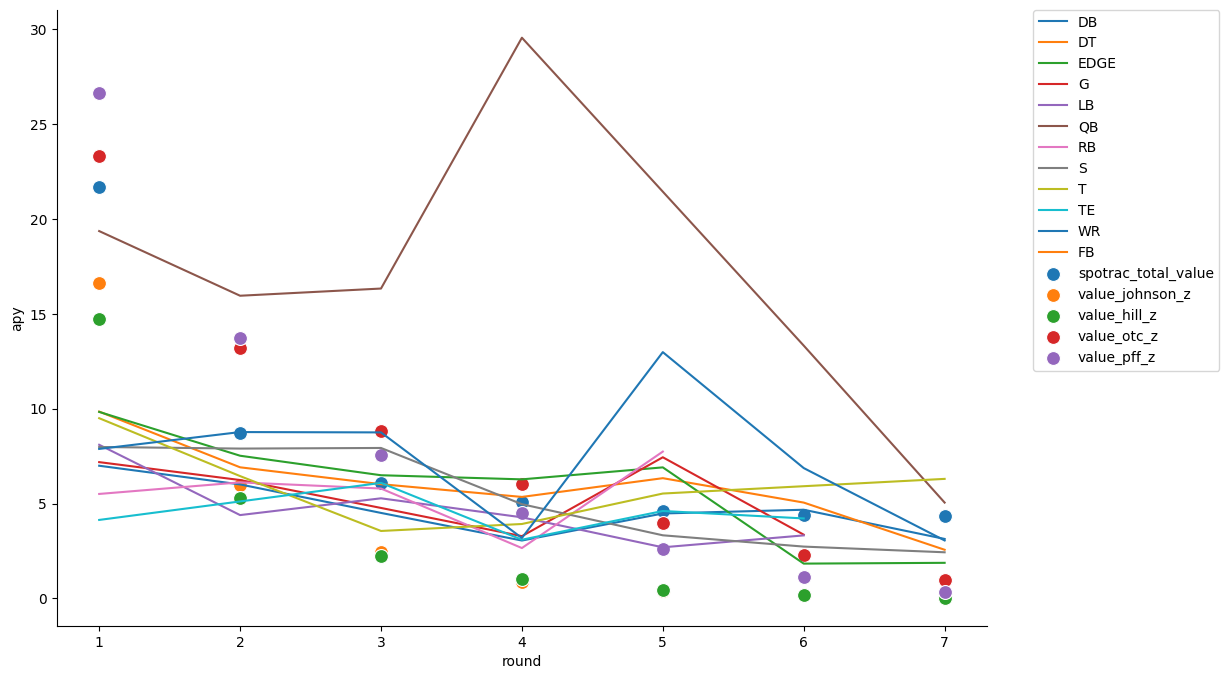

In [ ]:
f = plt.figure(figsize=(12,8))
_df = df_agg.loc[:, ['round','spotrac_total_value','value_johnson_z', 'value_hill_z', 'value_otc_z', 'value_pff_z']].groupby(['round'],as_index=False).mean()
for y in round_pos['position'].unique():
  sns.lineplot(data=round_pos.loc[round_pos['position']==y], x='round', y='apy',label=y)
for y in ['spotrac_total_value','value_johnson_z', 'value_hill_z', 'value_otc_z', 'value_pff_z']:
  sns.scatterplot(data=_df, x='round', y=y,label=y,s=100)

sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()